# Initial analysis 
This notebook lays out the initial analysis of the dataset and the ETL pipeline - transformations of data, drop unneccary columns, drop duplicates.<br>

__Please have in mind that there is some issue with both sqllite3 and sqlalchemy - I am able to write to an sql database, however, later, in the following notebook, I am not able to read from the created sqllite database. There is not so much information on the internet for this, so my workaround is to save the prepared data as pickle file and then load it. Please advise if you have found another solution, but the current solution that was provided also in the exercises, is not working__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter, FuncFormatter
%matplotlib inline

import sqlalchemy
import sqlite3
from cycler import cycler
from sqlalchemy.ext.declarative import declarative_base

import seaborn as sns
sns.set()

import regex as re

import os 
# environment settings
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

In [2]:
os.getcwd()

'/Users/asyagadzhalova/Documents/GitHub/disaster_messages_classification/notebooks'

In [3]:
os.chdir('..')

In [4]:
#read_data
messages = pd.read_csv(os.getcwd()+'/data/raw/disaster_messages.csv')
categories = pd.read_csv(os.getcwd()+'/data/raw/disaster_categories.csv')

## 1.Messages data

In [5]:
messages.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [6]:
messages.shape

(26248, 4)

### 1.1.Check for duplicates

In [7]:
#number of unique id-s
messages['id'].nunique()

26180

In [8]:
#number of rows
messages['id'].count()

26248

In [9]:
#repeat ids
messages['id'].value_counts().sort_values(ascending=False).head(10)

24779    3
19142    2
24247    2
23002    2
2446     2
18925    2
9131     2
27768    2
6393     2
19687    2
Name: id, dtype: int64

In [10]:
#drop duplicates on id level 
messages.drop_duplicates(subset='id',inplace=True)

In [11]:
messages.shape

(26180, 4)

In [12]:
#check for null values
messages.isnull().sum()

id              0
message         0
original    16027
genre           0
dtype: int64

### 1.2.Additional column

We will add one additional column indicating whether the message was translated or not. In case of missing original data, I assume the original is in english -> no translation.

In [13]:
#add new column - indicating whether there was a translation in English or not
messages['trans_ind'] = np.where(messages['original'].isnull()==True,0,np.where(messages['message']==messages['original'],0,1))

In [14]:
messages['trans_ind'].value_counts()

0    16054
1    10126
Name: trans_ind, dtype: int64

In [15]:
messages[messages['trans_ind']==1].head()

,id,message,original,genre,trans_ind
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1
5,14,Information about the National Palace-,Informtion au nivaux palais nationl,direct,1


In [16]:
messages['genre'].value_counts()

news      13039
direct    10747
social     2394
Name: genre, dtype: int64

In [17]:
messages[['genre','trans_ind']].value_counts()

genre   trans_ind
news    0            13039
direct  1            10126
social  0             2394
direct  0              621
dtype: int64

## 2.Categories 

In [18]:
pd.set_option('display.max_colwidth', None)
categories.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
1,7,related-1;request-0;offer-0;aid_related-1;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-1;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-1;floods-0;storm-1;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
2,8,related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
3,9,related-1;request-1;offer-0;aid_related-1;medical_help-0;medical_products-1;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-1;infrastructure_related-1;transport-0;buildings-1;electricity-0;tools-0;hospitals-1;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
4,12,related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0


In [19]:
categories.shape

(26248, 2)

### 2.1.Remove duplicates

In [20]:
categories.drop_duplicates(subset = ['id'],inplace=True)

In [21]:
categories.shape

(26180, 2)

In [22]:
categories.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
1,7,related-1;request-0;offer-0;aid_related-1;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-1;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-1;floods-0;storm-1;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
2,8,related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
3,9,related-1;request-1;offer-0;aid_related-1;medical_help-0;medical_products-1;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-1;infrastructure_related-1;transport-0;buildings-1;electricity-0;tools-0;hospitals-1;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0
4,12,related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0


### 2.2.Transform categories column into multiple columns
Transform the categories into different columns and then perform some additional cleaning on the new dataset

In [23]:
#categories_split = pd.Series(categories)
categories_new = categories['categories'].str.split(pat=';',expand=True)

In [24]:
categories_new.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-1,transport-0,buildings-1,electricity-0,tools-0,hospitals-1,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


#### 2.2.1. Change headings 
Use the first row for column names 

In [25]:
categories_new.columns = categories_new.iloc[0]

In [26]:
categories_new.head()

,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-1,transport-0,buildings-1,electricity-0,tools-0,hospitals-1,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


In [27]:
categories_new.columns

Index(['related-1', 'request-0', 'offer-0', 'aid_related-0', 'medical_help-0',
       'medical_products-0', 'search_and_rescue-0', 'security-0', 'military-0',
       'child_alone-0', 'water-0', 'food-0', 'shelter-0', 'clothing-0',
       'money-0', 'missing_people-0', 'refugees-0', 'death-0', 'other_aid-0',
       'infrastructure_related-0', 'transport-0', 'buildings-0',
       'electricity-0', 'tools-0', 'hospitals-0', 'shops-0', 'aid_centers-0',
       'other_infrastructure-0', 'weather_related-0', 'floods-0', 'storm-0',
       'fire-0', 'earthquake-0', 'cold-0', 'other_weather-0',
       'direct_report-0'],
      dtype='object', name=0)

#### 2.2.2.Clean the column names
Remove the numbers from the column names

In [28]:
new_list=[]

for col in categories_new.columns:
    new_col = col.split('-')[0]
    new_list.append(new_col)

In [29]:
new_list

['related',
 'request',
 'offer',
 'aid_related',
 'medical_help',
 'medical_products',
 'search_and_rescue',
 'security',
 'military',
 'child_alone',
 'water',
 'food',
 'shelter',
 'clothing',
 'money',
 'missing_people',
 'refugees',
 'death',
 'other_aid',
 'infrastructure_related',
 'transport',
 'buildings',
 'electricity',
 'tools',
 'hospitals',
 'shops',
 'aid_centers',
 'other_infrastructure',
 'weather_related',
 'floods',
 'storm',
 'fire',
 'earthquake',
 'cold',
 'other_weather',
 'direct_report']

In [30]:
categories_new.columns = new_list

In [31]:
categories_new.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-1,infrastructure_related-1,transport-0,buildings-1,electricity-0,tools-0,hospitals-1,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,water-0,food-0,shelter-0,clothing-0,money-0,missing_people-0,refugees-0,death-0,other_aid-0,infrastructure_related-0,transport-0,buildings-0,electricity-0,tools-0,hospitals-0,shops-0,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


#### 2.2.3.Transform the column values into just binary numbers

In [32]:
categories_new.columns

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object')

In [33]:
for col in categories_new.columns:
    categories_new[col]=categories_new[col].apply(lambda x: x.split('-')[1])
    categories_new[col]=pd.to_numeric(categories_new[col])

In [34]:
categories_new.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 2.3. Merge dataframes 

In [35]:
categories = categories.join(categories_new)

In [36]:
categories.head(2)

,id,categories,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,related-1;request-0;offer-0;aid_related-1;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-1;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-1;floods-0;storm-1;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


In [37]:
#drop initial column
categories.drop(['categories'],axis=1,inplace=True)

In [38]:
#create a complete dataframe with the messages and the categories
df = messages.merge(categories, how = 'inner', on = 'id')

In [39]:
df.shape

(26180, 41)

In [40]:
df.head()

,id,message,original,genre,trans_ind,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that could pass over Haiti,Un front froid se retrouve sur Cuba ce matin. Il pourrait traverser Haiti demain. Des averses de pluie isolee sont encore prevues sur notre region ce soi,direct,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ak timoun yo. Mesi se john jean depi Monben kwochi.",direct,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country today and tonight",facade ouest d Haiti et le reste du pays aujourd hui et ce soir,direct,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
#drop additional columns
df.drop(columns=['original'],axis=1,inplace=True)

## 3. Exploratory data analysis

In [42]:
df.describe()

,id,trans_ind,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.0,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000
mean,15227.563942,0.386784,0.773568,0.170512,0.004507,0.414095,0.079488,0.050076,0.027655,0.017991,0.032811,0.0,0.063751,0.111421,0.088159,0.015432,0.023033,0.011383,0.033384,0.045531,0.131436,0.065126,0.045798,0.050840,0.020321,0.006073,0.010810,0.004584,0.011803,0.043965,0.278304,0.082086,0.093201,0.010772,0.093659,0.020168,0.052559,0.193430
std,8827.269301,0.487023,0.435351,0.376089,0.066986,0.492574,0.270504,0.218107,0.163985,0.132920,0.178146,0.0,0.244313,0.314659,0.283531,0.123264,0.150011,0.106083,0.179641,0.208470,0.337883,0.246753,0.209051,0.219676,0.141098,0.077696,0.103409,0.067549,0.108000,0.205021,0.448172,0.274500,0.290719,0.103228,0.291360,0.140578,0.223156,0.394995
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7449.750000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15665.500000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22927.250000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
df.isnull().sum()

id                        0
message                   0
genre                     0
trans_ind                 0
related                   0
request                   0
offer                     0
aid_related               0
medical_help              0
medical_products          0
search_and_rescue         0
security                  0
military                  0
child_alone               0
water                     0
food                      0
shelter                   0
clothing                  0
money                     0
missing_people            0
refugees                  0
death                     0
other_aid                 0
infrastructure_related    0
transport                 0
buildings                 0
electricity               0
tools                     0
hospitals                 0
shops                     0
aid_centers               0
other_infrastructure      0
weather_related           0
floods                    0
storm                     0
fire                

In [44]:
df['related'].value_counts()

1    19876
0     6116
2      188
Name: related, dtype: int64

There is one column - related, that has three values - it is a categorical variable, rather than binary. Only 188 are the records with value 2. __I will remap those values to 1 for the following reasons:__
- this is highly imbalanced class so it will lead to distortions of the model; 
- I don't know what 2 indicates.

In [45]:
df.loc[df['related']==2,'related']=1

In [46]:
df['related'].value_counts()

1    20064
0     6116
Name: related, dtype: int64

### 3.1.Check for duplicated categories or constant categories

In [47]:
#find columns with the same value
col_list = []
for col in df.columns:
    if df[col].nunique()==1:
        col_list.append(col)

In [48]:
col_list

['child_alone']

In [49]:
#drop the category with only 0 values -> indicating there was not a message for child alone
df.drop(['child_alone'],axis=1,inplace=True)

In [50]:
#check whether the rest of the categories have only 2 values
col_list2 = []
for col in df.columns:
    if df[col].nunique()==2:
        col_list2.append(col)

set(df.columns) - set(col_list2) #expect only messages, id and genre columns

{'genre', 'id', 'message'}

#### Rows with all 0 categories

In [51]:
col_sum = ['related', 'request', 'offer',
       'aid_related', 'medical_help', 'medical_products', 'search_and_rescue',
       'security', 'military', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report']

In [52]:
list_rows_0 = []

for row in range(0,len(df)):
    k=0
    for col in col_sum:
        k +=df[col][row]
    if k == 0:
        list_rows_0.append(row)

In [53]:
#Number of rows without any category definition
len(list_rows_0)

6116

So there are 6116 rows that indicate no relevant information about the disaster - this is also indicated by column Related = 0 /the same number of rows have 0 values/ __We have imbalanced dataset__

Those are actually the rows that represent the category - Not related. It is omitted, which is ok for classifiers like SVC&LogRegression, but if we use Tree methods, we will have to add it as additional column.

### 3.2.ategories distribution

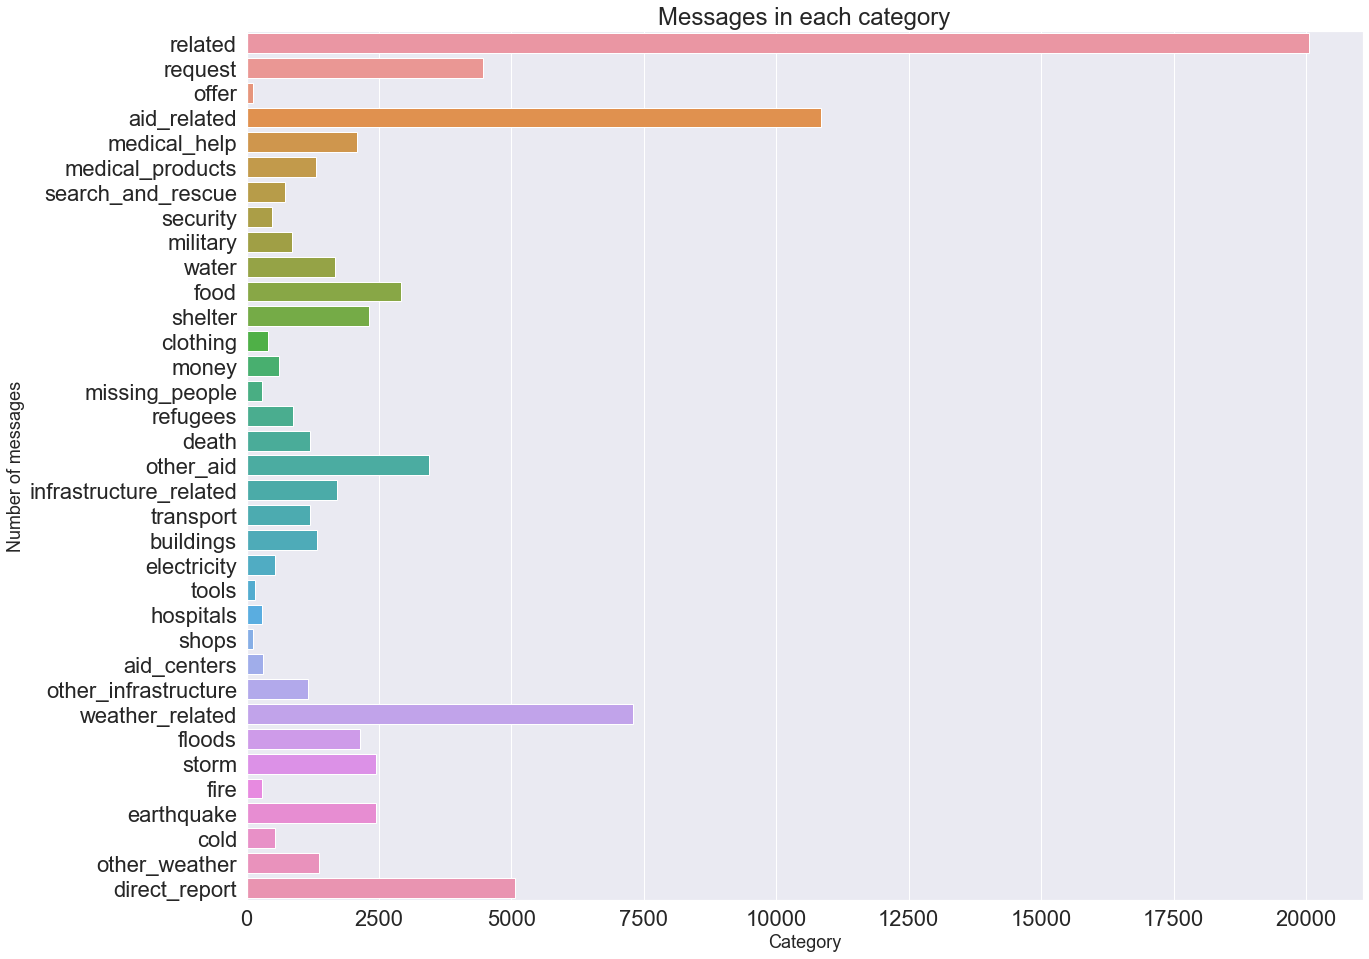

In [54]:
categories = col_sum
sns.set(font_scale = 2)
plt.figure(figsize=(20,16))

ax= sns.barplot(y = col_sum, x = df.iloc[:,4:].sum().values, orient='h')
plt.title("Messages in each category", fontsize=24)
plt.ylabel('Number of messages', fontsize=18)
plt.xlabel('Category', fontsize=18);
#plt.xticks(rotation=90);

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


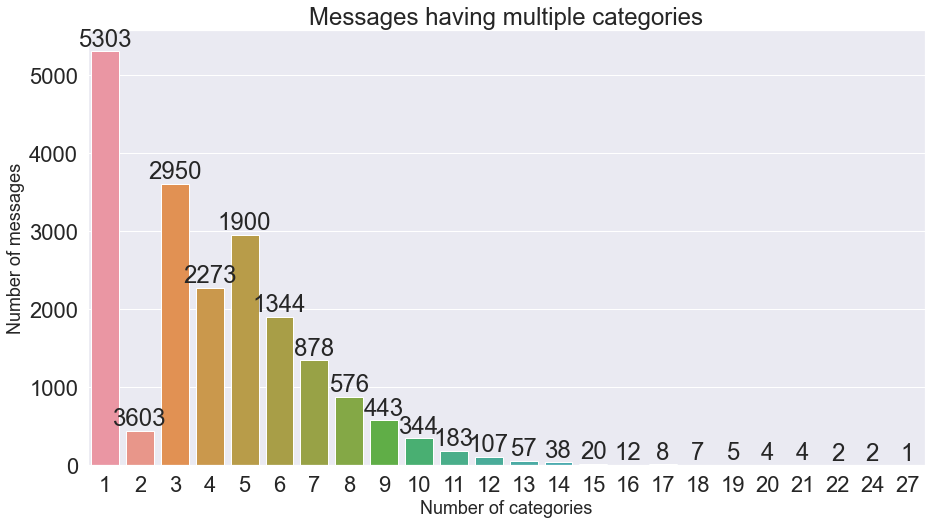

In [55]:
rowSums = df.iloc[:,4:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]

plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Messages having multiple categories")
plt.ylabel('Number of messages', fontsize=18)
plt.xlabel('Number of categories', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [56]:
#how many messages have only Related category, and no other category?
list_1_category = rowSums[rowSums==1].index.to_list()
df.iloc[list_1_category]['related'].sum()

5303

All messages with 1 category are marked as Related category -> everything that cannot be classified into the other, is Related. Since Related ==0 is for 6116 rows, the number of rows with empty data, it means that for the other rows with more than 1 category, always one of the categories is Related.<br>
Hence, once the message is received, it is either clasified as:

- in more than 1 category, with one of them being Related;
- only as Related;
- or as no category

In [62]:
df.to_pickle(os.getcwd()+'/data/processed/data_after_eda.pkl')

In [58]:
#conn = sqlite3.connect('disaster_response.db')
#df.to_sql(name='messages', con=conn)

In [61]:
def save_data(df,database_name):
    engine = sqlalchemy.create_engine('sqlite:///{}'.format(database_name))
    df.to_sql('table_message', engine,if_exists='replace')

In [62]:
save_data(df,'disaster_response.db')

In [62]:
#engine = sqlalchemy.create_engine('sqlite:///DisasterResponse.db')
#df.to_sql('table_messages', engine,if_exists='replace')
#Base = declarative_base()
#Base.metadata.create_all(engine) 

In [54]:
#engine.table_names()

/var/folders/xx/52xcnk8x57b6lb5ws1h4mj2c0000gn/T/ipykernel_5489/4162273999.py:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  engine.table_names()


['table_messages']